In [1]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

def list_png_files(root_dir):
    png_files = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith('.png'):
                full_path = os.path.join(subdir, file)
                png_files.append(full_path)
    return png_files

train_dir = '../input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train'
val_dir = '../input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val'
test_dir = '../input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test'

train_png_files = list_png_files(train_dir)
val_png_files = list_png_files(val_dir)
test_png_files = list_png_files(test_dir)

2024-05-01 11:23:42.584855: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 11:23:42.584995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 11:23:42.755817: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def parse_image(filename):
    parts = tf.strings.split(filename, os.sep)
    label = parts[-2] == 'fractured'  # Example for binary labels based on folder names
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = image / 255.0
    return image, tf.cast(label, tf.int32)

train_dataset = tf.data.Dataset.from_tensor_slices(train_png_files)
train_dataset = train_dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(64).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(val_png_files)
val_dataset = val_dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_png_files)
test_dataset = test_dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

# Define Pretrained Base

In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Load the VGG16 model, pretrained on ImageNet data
pretrained_base = VGG16(weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [4]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    # YOUR CODE HERE. Attach a head of dense layers.
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


In [5]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss = 'binary_crossentropy',
    metrics=['binary_accuracy'],
)


In [6]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 9s/step - binary_accuracy: 0.6402 - loss: 0.7025 - val_binary_accuracy: 0.6949 - val_loss: 0.6251
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 9s/step - binary_accuracy: 0.6402 - loss: 0.6207 - val_binary_accuracy: 0.6949 - val_loss: 0.5194
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - binary_accuracy: 0.6454 - loss: 0.5203 - val_binary_accuracy: 0.6949 - val_loss: 0.4282
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 9s/step - binary_accuracy: 0.6439 - loss: 0.4627 - val_binary_accuracy: 0.8983 - val_loss: 0.4086
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - binary_accuracy: 0.8517 - loss: 0.3917 - val_binary_accuracy: 0.8814 - val_loss: 0.4401
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 9s/step - binary_accuracy: 0.8924 - loss: 0.4279 - val_binary_accuracy: 0.8983 - val_loss: 0.3682
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 9s/step - binary_accuracy: 0.8747 - loss: 0.3523 - val_binary_accuracy: 0.8983 - val_loss: 0.2750
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━

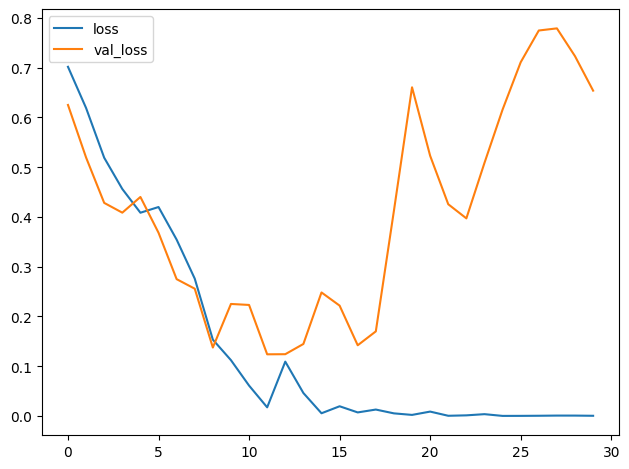

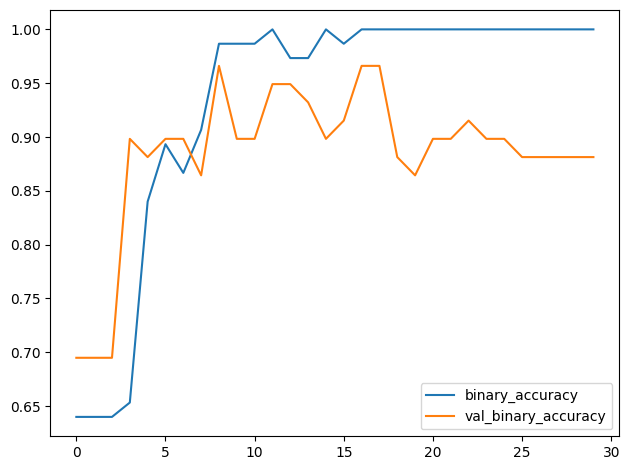

In [7]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [8]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - binary_accuracy: 0.9298 - loss: 0.3903
Test Loss: 0.39029791951179504
Test Accuracy: 0.9298245906829834
